# Vol. 2. Machine learning-based prediction of blast movement using Quantile regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Raw BMM spreadsheet cleaning

Now that we are dealing with an almost-ready-to-use file, we just need to do some more cleaning. Let's take a look how the new file looks.

In [2]:
df_raw = pd.read_excel('obtained_data.xlsx', usecols=lambda column: column != 'Unnamed: 0')
df_raw.iloc[:,3:].head()

,elev,bmm_elev,expl_type,confined,bp_h,inst_depth,inst_h,det_depth,det_h,act_dir,...,bp_pf,ideal_dir,voronoi_rock_vol,loc_dh_len,loc_expl_len,loc_stem_len,loc_expl_mass,booster,dist_first,loc_to_first_dir
0,474.667,470.967,ANFO,free face,4.667,3.7,0.967,4.282504,1.061496,161.867800,...,0.318216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,474.667,472.967,ANFO,free face,4.667,1.7,2.967,2.033786,3.229214,187.461599,...,0.318216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,474.601,470.901,ANFO,free face,4.601,3.7,0.901,5.423375,0.376625,151.617502,...,0.318216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,474.601,472.901,ANFO,free face,4.601,1.7,2.901,2.239060,3.802940,188.005486,...,0.318216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,475.126,471.426,ANFO,free face,5.126,3.7,1.426,4.148262,1.383738,228.806465,...,0.318216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_raw.shape

(1305, 32)

So far, the file has loaded all the necessary data. Now we have to drop the rows with missing information. This is due to having some observations which did not match with the blast design data. I would say that imputing missing blast design features is not be a good idea.

In [4]:
df_raw = df_raw.dropna().reset_index(drop=True)

Once more, we load the gas products dictionary for both explosive types.

In [5]:
expl_gas_prod_dict = {
    'ANFO': 988,
    'Riogel': 933
}

Some additional features were engineered and introduced as columns to the dataframe including:
- Post-blast panel height (m)
- Horizontal movement deviation angle (°) - Angle deviating from ideal movement direction
- Horizontal movement towards free face (m) - Horizontal movement vector major component, following the ideal movement direction
- Horizontal movement deviation (m) - Horizontal movement vector minor component, orthogonal to the ideal movement direction
- Local powder factor (kg/m³) - Ratio between of explosives mass and Voronoi rockmass in proximity to monitoring location
- Local gas products factor (l/m³) - Ratio between volume of explosive gas products and Voronoi rockmass in proximity to monitoring location
- Total ammount of gas products in proximity to monitoring location (l)
- Distance towards free face (m) - Distance to first row drillholes

In [6]:
df_raw['bp_post_h'] = df_raw['det_h'] + df_raw['det_depth']

In [7]:
df_raw['h_dev_angle'] = np.abs(df_raw['ideal_dir'] - df_raw['act_dir'])
df_raw['h_dev_angle'] = df_raw.apply(
    lambda row: -row['h_dev_angle'] if (0 <= row['loc_to_first_dir'] < 90 or 180 <= row['loc_to_first_dir'] < 270) 
    else row['h_dev_angle'], 
    axis=1
)

In [8]:
df_raw['m_h_ff'] = np.cos(np.deg2rad(df_raw['h_dev_angle'] )) * df_raw['m_h']
df_raw['m_h_dev'] = np.sin(np.deg2rad(df_raw['h_dev_angle'] )) * df_raw['m_h']

In [9]:
df_raw['loc_pf'] = df_raw['loc_expl_mass'] / df_raw['voronoi_rock_vol']
df_raw['loc_gpf'] = df_raw['loc_pf'] * df_raw['expl_type'].map(expl_gas_prod_dict)
df_raw['loc_gp_vol'] = df_raw['loc_expl_mass'] * df_raw['expl_type'].map(expl_gas_prod_dict)

In [10]:
df_raw['dist_ff'] = np.abs(df_raw['dist_first'] * np.cos(np.radians(df_raw['loc_to_first_dir'])))

In [11]:
df_raw.iloc[:,3:].head()

,elev,bmm_elev,expl_type,confined,bp_h,inst_depth,inst_h,det_depth,det_h,act_dir,...,dist_first,loc_to_first_dir,bp_post_h,h_dev_angle,m_h_ff,m_h_dev,loc_pf,loc_gpf,loc_gp_vol,dist_ff
0,474.938,471.138,ANFO,free face,4.938,3.8,1.138,4.626556,0.677444,141.107178,...,33.382023,-81.043613,5.304,0.613786,1.036787,0.011107,0.357001,352.717385,109053.0688,5.197
1,474.938,473.238,ANFO,free face,4.938,1.7,3.238,1.983379,3.466621,146.309932,...,33.382023,-81.043613,5.450,4.588968,1.484319,0.119138,0.357001,352.717385,109053.0688,5.197
2,475.110,471.510,ANFO,free face,5.110,3.6,1.510,4.491994,1.098006,136.568421,...,33.619441,-45.097612,5.590,6.737284,1.180178,0.139418,0.353972,349.723846,130457.8912,23.732
3,475.110,473.410,ANFO,free face,5.110,1.7,3.410,2.319462,3.435538,143.513696,...,33.619441,-45.097612,5.755,0.207990,1.643026,0.005964,0.353972,349.723846,130457.8912,23.732
4,474.824,471.224,ANFO,free face,4.824,3.6,1.224,3.974748,1.129252,136.533220,...,49.921806,-31.932997,5.104,22.063049,1.494023,0.605538,0.352243,348.016277,122536.8976,42.367


In [12]:
df_raw.shape

(1187, 40)

ALthoug missing values were dropped and no imputations were meade, we still have lots of data to analyze. 

In [13]:
df_raw.columns

Index(['bp_id', 'east', 'north', 'elev', 'bmm_elev', 'expl_type', 'confined',
       'bp_h', 'inst_depth', 'inst_h', 'det_depth', 'det_h', 'act_dir',
       'act_incl', 'm_3d', 'm_h', 'm_v', 'date', 'bp_drill_m', 'bp_vol',
       'bp_mass', 'bp_expl_mass', 'bp_pf', 'ideal_dir', 'voronoi_rock_vol',
       'loc_dh_len', 'loc_expl_len', 'loc_stem_len', 'loc_expl_mass',
       'booster', 'dist_first', 'loc_to_first_dir', 'bp_post_h', 'h_dev_angle',
       'm_h_ff', 'm_h_dev', 'loc_pf', 'loc_gpf', 'loc_gp_vol', 'dist_ff'],
      dtype='object')

Additional conditions for outliers were adopted for this analysis, which refer not only to movement results, but also to engineering conditions.

They include the following criteria:
- Blastes which do not employ boosters are disregarde, as no blast can occur without a booster.
- Installation height below 0.1 m are considered outliers
- Distances from the free face lower than 5 m and above 110 m are considered outliers as they have singular observations (this may have to be relaxed in the future when additional data is collected)
- Horizontal movement deviation angle is constrained between -90° and 90° as backwards movement is considered highly improbable.
-  Horizontal movement above 3.5 m is considered to be highly irregular and rare and hence samples are deemed outlers
-  Vertical movement vectors with values below -1 m and above 2 m are considered to be highly irregular and rare and hence samples are deemed outlers
-  Horizontal movement deviation vectors with values below -1 m and above 1.5 m are considered to be highly irregular and rare and hence samples are deemed outlers

In [14]:
conditions = (df_raw['booster'] > 0.400) \
            & (df_raw['inst_h'] > 0.1) \
            & (df_raw['dist_ff'] >= 5) & (df_raw['dist_ff'] <= 110) \
            & (df_raw['loc_gpf'] <= 700) \
            & (df_raw['h_dev_angle'] <= 90) & (df_raw['h_dev_angle'] >= -90)\
            & (df_raw['m_h_ff'] >= 0) & (df_raw['m_h_ff'] <= 3.5) \
            & (df_raw['m_v'] >= -1 ) & (df_raw['m_v'] <= 2 ) \
            & (df_raw['m_h_dev'] >= -1) & (df_raw['m_h_dev'] <= 1.5)

df = df_raw[conditions].copy()
df.iloc[:,3:].head()

,elev,bmm_elev,expl_type,confined,bp_h,inst_depth,inst_h,det_depth,det_h,act_dir,...,dist_first,loc_to_first_dir,bp_post_h,h_dev_angle,m_h_ff,m_h_dev,loc_pf,loc_gpf,loc_gp_vol,dist_ff
0,474.938,471.138,ANFO,free face,4.938,3.8,1.138,4.626556,0.677444,141.107178,...,33.382023,-81.043613,5.304,0.613786,1.036787,0.011107,0.357001,352.717385,109053.0688,5.197
1,474.938,473.238,ANFO,free face,4.938,1.7,3.238,1.983379,3.466621,146.309932,...,33.382023,-81.043613,5.450,4.588968,1.484319,0.119138,0.357001,352.717385,109053.0688,5.197
2,475.110,471.510,ANFO,free face,5.110,3.6,1.510,4.491994,1.098006,136.568421,...,33.619441,-45.097612,5.590,6.737284,1.180178,0.139418,0.353972,349.723846,130457.8912,23.732
3,475.110,473.410,ANFO,free face,5.110,1.7,3.410,2.319462,3.435538,143.513696,...,33.619441,-45.097612,5.755,0.207990,1.643026,0.005964,0.353972,349.723846,130457.8912,23.732
4,474.824,471.224,ANFO,free face,4.824,3.6,1.224,3.974748,1.129252,136.533220,...,49.921806,-31.932997,5.104,22.063049,1.494023,0.605538,0.352243,348.016277,122536.8976,42.367


In [15]:
df.shape

(1106, 40)

Only 81 observations were dropped, which still leaves us with lots of data to analyze and use for predictive modelling.

In [16]:
df.iloc[:,3:].head()

,elev,bmm_elev,expl_type,confined,bp_h,inst_depth,inst_h,det_depth,det_h,act_dir,...,dist_first,loc_to_first_dir,bp_post_h,h_dev_angle,m_h_ff,m_h_dev,loc_pf,loc_gpf,loc_gp_vol,dist_ff
0,474.938,471.138,ANFO,free face,4.938,3.8,1.138,4.626556,0.677444,141.107178,...,33.382023,-81.043613,5.304,0.613786,1.036787,0.011107,0.357001,352.717385,109053.0688,5.197
1,474.938,473.238,ANFO,free face,4.938,1.7,3.238,1.983379,3.466621,146.309932,...,33.382023,-81.043613,5.450,4.588968,1.484319,0.119138,0.357001,352.717385,109053.0688,5.197
2,475.110,471.510,ANFO,free face,5.110,3.6,1.510,4.491994,1.098006,136.568421,...,33.619441,-45.097612,5.590,6.737284,1.180178,0.139418,0.353972,349.723846,130457.8912,23.732
3,475.110,473.410,ANFO,free face,5.110,1.7,3.410,2.319462,3.435538,143.513696,...,33.619441,-45.097612,5.755,0.207990,1.643026,0.005964,0.353972,349.723846,130457.8912,23.732
4,474.824,471.224,ANFO,free face,4.824,3.6,1.224,3.974748,1.129252,136.533220,...,49.921806,-31.932997,5.104,22.063049,1.494023,0.605538,0.352243,348.016277,122536.8976,42.367


Everything seems in order. Let's save it just in case!

In [17]:
df.to_excel('new_cleaned_data.xlsx')

## Traning and testing quantile regression models

As the training and testing of multiple models can be a bit tedious, a few functions were defined to make the process qikcer and easily adjustable.

### Defining key analysis and plotting functions

In [18]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score, learning_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_halving_search_cv, enable_halving_search_cv
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore", message="The total space of parameters .* smaller than n_iter=")

As the osbervations are highly scattered, a binned scatter plot, based on the average and different quantile values is created to make feature selection easier.

In [19]:
def plot_binned_scatterplots(df, feature, target, bin_list, tau=0.5):
    """
    Plots scatterplots with binned data for a range of bin configurations, side by side.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    feature (str): The name of the feature column.
    target (str): The name of the target column.
    bin_list (list): List of integers defining the number of bins for each plot.
    tau (float): Quantile level (default is 0.5 for median).
    """
    n_plots = len(bin_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4), sharey=True)
    
    if n_plots == 1:  # If only one plot is requested
        axes = [axes]
    
    for ax, bins in zip(axes, bin_list):
        # Define bin edges
        bin_edges = np.linspace(df[feature].min(), df[feature].max(), bins + 1)
        labels = [f"{round(bin_edges[i], 2)}-{round(bin_edges[i + 1], 2)}" for i in range(len(bin_edges) - 1)]

        # Bin the feature values
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=bin_edges, labels=labels, include_lowest=True)

        # Calculate bin centers for all bins
        bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

        # Group by bins and compute statistics
        grouped = df.groupby(f'{feature}_bin', observed=True)
        mean_y = grouped[target].mean()
        percentile_y = grouped[target].quantile(tau)

        # Filter only valid bins (those that contain data)
        valid_bins = mean_y.index[~mean_y.isna()]
        valid_bin_centers = [bin_centers[i] for i in range(len(labels)) if labels[i] in valid_bins]

        # Drop NaN values to align lengths
        mean_y = mean_y.dropna()
        percentile_y = percentile_y.dropna()

        # Plot
        ax.scatter(df[feature], df[target], alpha=0.6, label='Data points', color='gray', s=25)
        ax.scatter(valid_bin_centers, mean_y.values, color='red', label='Mean', s=50, zorder=5)
        ax.scatter(valid_bin_centers, percentile_y.values, color='blue', label=f'P {tau*100:.1f}', s=50, zorder=5)
        ax.set_title(f'Scatter Plot with {bins} Bins')
        ax.set_xlabel(feature)
        ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--', alpha=0.7)
        ax.grid(alpha=0.3)

    axes[0].set_ylabel(target)
    axes[-1].legend(fontsize=12)
    plt.tight_layout()
    plt.show()


As a quantile regression is the choice of modelling framework, hence, the *quantile loss* function is defined as way to measure loss.

In [20]:
def quantile_loss_ml(y_true, y_pred, quantile=0.5):
    diff = y_true - y_pred
    return np.mean(np.maximum(quantile * diff, (1 - quantile) * -diff))

This functions provides a way to plot the learning curve for an arbitrary model using k-fold cross validation.

In [21]:
def plot_ml_learning_curve(name, model, X_train_scaled, y_train, quantile=0.5, k_folds=5):
    '''
    Validate model through 5-fold cross validation and plot learning curve
    '''    
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=quantile_loss_scorer)
    
    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_scaled,  # Features
        y_train,  # Target
        cv=kf,
        scoring=quantile_loss_scorer,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    # Compute mean and standard deviation of scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.figure(figsize=(8, 3))
    plt.title(f"Learning Curve for {name} (Q={quantile:.2f})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Quantile Loss")
    plt.grid()
    
    # Plot mean and std deviation for training and test scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()
    
    # Print cross-validation results
    cv_scores_mean = -np.mean(cv_scores)
    cv_scores_std = np.std(cv_scores)
    
    print(f"Cross-validated quantile loss: {cv_scores_mean:.4f} ± {cv_scores_std:.4f}")

In [22]:
def test_ml_model(model, X_train, y_train, X_test, y_test, quantile):
    y_pred_train = model.predict(X_train)
    quantile_loss_train = quantile_loss_ml(y_train, y_pred_train, quantile)
    
    y_pred_test = model.predict(X_test)
    quantile_loss_test = quantile_loss_ml(y_test, y_pred_test, quantile)
    
    print(f"Quantile Loss on Train Set: {quantile_loss_train:.4f}")
    print(f"Quantile Loss on Test Set: {quantile_loss_test:.4f}")
    print()
    print()
    
    return y_pred_test

In [23]:
def plot_predict_hist(y_test, predictions, target):
    all_predictions = np.concatenate(list(predictions.values()))
    
    plt.figure(figsize=(7, 3))
    plt.hist(all_predictions, bins=25, alpha=0.5, edgecolor='black', label='Predicted', density=True)
    plt.hist(y_test, bins=25, alpha=0.5, edgecolor='black', label='Actual', density=True)
    plt.title('Histogram of Predicted Results for Quantiles')
    plt.xlabel(target)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [24]:
def plot_predict_scatter(X_test, y_test, predictions, quantiles, predictors_list, target):
    """
    Plots scatter plots of predictions and true values against predictors.
    """
    all_predictions = np.concatenate(list(predictions.values()))  # Combine predictions for all quantiles
    
    # Handle cases with a single predictor
    if X_test.shape[1] == 1:
        predictor_values = np.tile(X_test.values.flatten(), len(quantiles))
        
        plt.figure(figsize=(7, 3))
        plt.scatter(predictor_values, all_predictions, color='tab:blue', alpha=0.2, s=5, label='Predictions')
        plt.scatter(X_test.values.flatten(), y_test, color='black', alpha=0.5, s=10, label='True Values')
        plt.xlabel(predictors_list[0])
        plt.ylabel(target)
        plt.legend()
        plt.title(f'Scatter Plot for {predictors_list[0]}')
    
    # Handle cases with multiple predictors
    else:
        num_predictors = len(predictors_list)
        fig, axes = plt.subplots(1, num_predictors, figsize=(5 * num_predictors, 3))
        
        if num_predictors == 1:  # Single subplot for one predictor
            axes = [axes]
        
        for i, ax in enumerate(axes):
            predictor_values = np.tile(X_test.values[:, i], len(quantiles))
            ax.scatter(predictor_values, all_predictions, color='tab:blue', alpha=0.2, s=5, label='Predictions')
            ax.scatter(X_test.values[:, i], y_test, color='black', alpha=0.5, s=10, label='True Values')
            ax.set_xlabel(predictors_list[i])
            ax.set_ylabel(target)
            ax.legend()
            ax.set_title(f'Scatter Plot for {predictors_list[i]}')
        
        plt.tight_layout()

    plt.show()

### Defining key models

For the purpose a 5-fold cross validation strategy was used for establishing best hyperparameters of three models:
- Linear model
- Gradient boosted trees (GBT)
- Histogram-based gradient boosted trees (for the sake of speeding up the work and approximating the rsults of GBTs)

In [25]:
from sklearn.linear_model import QuantileRegressor

def train_cv_lqr(X_train, y_train, quantile=0.5,  cv=5):
    """
    Trains a Quantile Linear Regression model using Halving Random Search CV with NumPy arrays.
    """        
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    # Define the Quantile Regressor model
    quantile_reg = QuantileRegressor(quantile=quantile, solver='highs')
    
    # Define the parameter grid
    param_grid = {
        'alpha': np.logspace(-10, 1, 100),        # Regularization strength
        'solver': ['highs'],
        # 'fit_intercept': [True]
    }
    
    # Perform Halving Random Search
    quantile_halving_random_search = HalvingRandomSearchCV(
        estimator=quantile_reg,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the search
    quantile_halving_random_search.fit(X_train, y_train)

    return quantile_halving_random_search

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

def train_cv_gt_qr(X_train, y_train, quantile=0.5, cv=5):
    """
    Trains a Decision Tree Ensemble (Gradient Boosting) for Quantile Regression using Halving Random Search CV.
    """    
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    # Define the Gradient Boosting Regressor for Quantile Regression
    gbr = GradientBoostingRegressor(loss='quantile', alpha=quantile)

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100],         # Number of boosting stages
        'max_depth': [4],                # Maximum depth of trees
        'learning_rate': [0.001, 0.01, 0.1, 0.2],     # Shrinkage rate
        'min_samples_split': [2, 5, 10],       
        'min_samples_leaf': [1, 3, 5],         
        'subsample': [0.6, 0.8, 1.0]           
    }

    # Perform Halving Random Search
    halving_search = HalvingRandomSearchCV(
        estimator=gbr,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1
    )

    # Fit the search to the data
    halving_search.fit(X_train, y_train)

    return halving_search

In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

def train_cv_hbgt_qr(X_train, y_train, quantile=0.5, cv=5):
    """
    Trains a Histogram-based Gradient Boosting Regressor using quantile regression
    with Halving Random Search CV.
    """   
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)
    
    # Define the HistGradientBoostingRegressor with quantile loss
    hist_gbr = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
    
    # Define the parameter grid
    param_grid = {
        'max_iter': [50, 100],
        'learning_rate': np.logspace(-5, 0, 10),
        'max_depth': [5, 10],
        'max_bins': [5, 15, 20],
        'l2_regularization': np.logspace(-4, 1, 5),
    }
    
    # Perform Halving Random Search
    halving_random_search = HalvingRandomSearchCV(
        estimator=hist_gbr,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1,
    )
    
    # Fit the search
    halving_random_search.fit(X_train, y_train)
    
    return halving_random_search

In [28]:
def build_nn_model(X_train, y_train, quantile):
    n_features = X_train.shape[1]
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(2, activation='tanh'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss=lambda y, y_pred: quantile_loss_dl(y, y_pred, quantile))
    return model

In [29]:
def store_ml_model_data(model_name, X_train_scaled, y_train, X_test_scaled, y_test, k_folds, quantiles):
    models = {}
    predictions = {}
    
    for quantile in quantiles:
        quantile = np.round(quantile, 2)
        if model_name == 'Linear model':
            model = train_cv_lqr(X_train_scaled, y_train, quantile)
        elif model_name == 'Gradient trees':
            model = train_cv_gt_qr(X_train_scaled, y_train, quantile)
        elif model_name == 'Histogram-based gradient trees':
            model = train_cv_hbgt_qr(X_train_scaled, y_train, quantile)
        
        best_model = model.best_estimator_
        y_pred_quantile = best_model.predict(X_test_scaled)
        plot_ml_learning_curve(model_name, best_model, X_train_scaled, y_train, quantile, k_folds)
        full_model = best_model.fit(X_train_scaled, y_train)
    
        y_pred_test = test_ml_model(full_model, X_train_scaled, y_train, X_test_scaled, y_test, quantile)
        
        models[quantile] = model
        predictions[quantile] = y_pred_test

    return models, predictions

In [30]:
def store_dl_model_data(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, quantiles, epochs=35, batch_size=64):
    models = {}
    predictions = {}
    
    for quantile in quantiles:
        quantile = np.round(quantile, 2)
        model = build_nn_model(X_train_scaled, y_train, quantile)
        history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val), verbose=0)
        plot_dl_learning_curve(history, quantile)
        
        y_pred_test = test_dl_model(model, X_test_scaled, y_test, quantile)
        
        models[quantile] = model
        predictions[quantile] = y_pred_test

    return models, predictions

### Aim and objectives

The aim of the study is to establish all 4 blast movement parameters: 
- Horizontal movement towards free face (m)
- Horizontal movement deviation vector (m)
- Vertical movement vector (m)
- Blast panel height post-blasting (m)

  
In order to achieve this result, several key objectives need to be solved:
1. Evaluate which features affect the 4 parameters of blast movement
2. Evaluate the predictive perofrmance of different quantile regression models
3. Deploy and test models for conditional simulation of blast movement

In [31]:
targets = ['m_h_ff', 'm_v', 'm_h_dev', 'det_depth']

In [32]:
quantiles = np.arange(0.1, 1.0, 0.1)

### Horizontal movement prediction

#### Feature selection

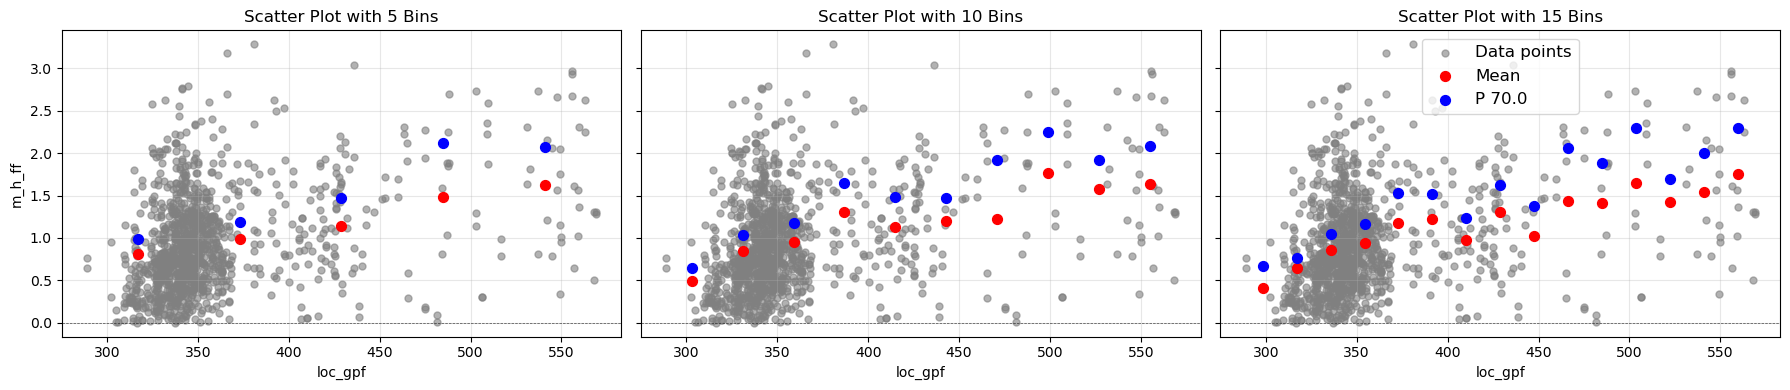

In [33]:
plot_binned_scatterplots(df, 'loc_gpf', 'm_h_ff', bin_list=[5, 10, 15], tau=0.7)

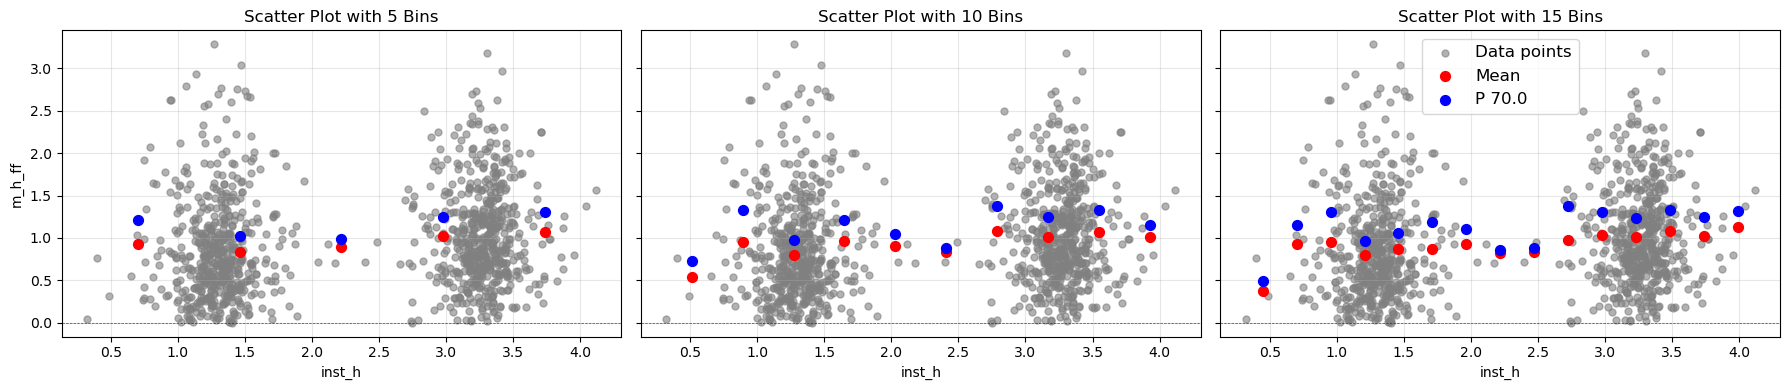

In [34]:
plot_binned_scatterplots(df, 'inst_h', 'm_h_ff', bin_list=[5, 10, 15], tau=0.7)

#### Training preparation

In [35]:
predictors_m_h_ff = [
    'inst_h',
    'loc_gpf',
]

In [36]:
k_folds = 5
partition = 0.2

In [37]:
train_m_h_ff, test_m_h_ff = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_h_ff, y_train_m_h_ff = train_m_h_ff[predictors_m_h_ff], train_m_h_ff[targets[0]]
X_test_m_h_ff, y_test_m_h_ff = test_m_h_ff[predictors_m_h_ff], test_m_h_ff[targets[0]]

# Initialize QuantileTransformer for the target column
x_scaler_m_h_ff = StandardScaler()

# Scale X (features)
X_train_scaled_m_h_ff = x_scaler_m_h_ff.fit_transform(X_train_m_h_ff)
X_test_scaled_m_h_ff = x_scaler_m_h_ff.transform(X_test_m_h_ff)

In [38]:
test_m_h_ff

,bp_id,east,north,elev,bmm_elev,expl_type,confined,bp_h,inst_depth,inst_h,...,bp_post_h,h_dev_angle,m_h_ff,m_h_dev,loc_pf,loc_gpf,loc_gp_vol,dist_ff,loc_gpf_bin,inst_h_bin
347,PB1_440_001,9435613.257,4523370.088,445.042,441.342,ANFO,free face,5.042,3.7,1.342,...,5.666,4.788978,0.322907,0.027053,0.335464,331.438256,122899.4936,91.800,326.36-345.01,1.33-1.59
773,PB1_425_006,9435547.082,4523473.864,429.675,428.075,Riogel,choked,4.675,1.6,3.075,...,5.472,3.744169,0.957280,0.062646,0.324048,302.337178,103789.7190,44.858,289.06-307.71,2.85-3.1
65,PB1_460_003,9435603.762,4523460.858,464.867,461.067,ANFO,free face,4.867,3.8,1.067,...,5.194,38.001781,1.763143,1.377607,0.346123,341.969052,108609.6544,38.108,326.36-345.01,0.83-1.08
731,PB2_430_003,9435590.296,4523660.627,434.848,431.248,ANFO,free face,4.848,3.6,1.248,...,5.953,-35.159020,0.369989,-0.260602,0.347439,343.270177,121441.7984,13.756,326.36-345.01,1.08-1.33
515,PB2_450_003,9435572.575,4523642.833,454.513,452.913,Riogel,choked,4.513,1.6,2.913,...,5.092,61.897160,0.145259,0.272014,0.326876,304.975356,100846.5705,29.759,289.06-307.71,2.85-3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,PB3_450_005,9435655.568,4523741.269,454.746,453.146,Riogel,choked,4.746,1.6,3.146,...,5.151,83.058254,0.026522,0.217838,0.339218,316.489973,109688.8914,33.796,307.71-326.36,3.1-3.36
617,PB2_440_001,9435592.796,4523677.423,444.781,443.181,ANFO,choked,4.781,1.6,3.181,...,5.728,11.351223,0.708529,0.142237,0.351593,347.373566,120151.8656,8.742,345.01-363.66,3.1-3.36
1075,PB2_435_006,9435542.308,4523621.567,439.958,436.358,ANFO,free face,4.958,3.6,1.358,...,5.795,-3.824111,1.185366,-0.079233,0.361167,356.833027,127636.1632,13.525,345.01-363.66,1.33-1.59
1074,PB2_430_013,9435653.571,4523557.715,434.802,433.202,ANFO,choked,4.802,1.6,3.202,...,5.985,33.356184,0.245983,0.161926,0.345826,341.676213,122180.8224,10.224,326.36-345.01,3.1-3.36


In [39]:
aaaaaa

NameError: name 'aaaaaa' is not defined

#### Linear quantile regression

In [ ]:
start_t = time.time()
models_lqr_m_h_ff, predictions_lqr_m_h_ff = store_ml_model_data('Linear model', 
                                                                X_train_scaled_m_h_ff, 
                                                                y_train_m_h_ff, 
                                                                X_test_scaled_m_h_ff, 
                                                                y_test_m_h_ff, 
                                                                k_folds, 
                                                                quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_lqr_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

#### Gradient trees quantile regression

In [ ]:
start_t = time.time()
models_gt_m_h_ff, predictions_gt_m_h_ff = store_ml_model_data('Gradient trees', 
                                                              X_train_scaled_m_h_ff, 
                                                              y_train_m_h_ff, 
                                                              X_test_scaled_m_h_ff, 
                                                              y_test_m_h_ff, 
                                                              k_folds, 
                                                              quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_gt_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

#### Histogram-based gradient trees quantile regression

In [ ]:
start_t = time.time()
models_hbgt_m_h_ff, predictions_hbgt_m_h_ff = store_ml_model_data('Histogram-based gradient trees', 
                                                                  X_train_scaled_m_h_ff, 
                                                                  y_train_m_h_ff, 
                                                                  X_test_scaled_m_h_ff, 
                                                                  y_test_m_h_ff, 
                                                                  k_folds, 
                                                                  quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_hbgt_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

### Vertical movement prediction

#### Feature selection

In [ ]:
plot_binned_scatterplots(df, 'inst_h', 'm_v', bin_list=[5, 10, 15], tau=0.5)

In [ ]:
plot_binned_scatterplots(df, 'm_h_ff', 'm_v', bin_list=[5, 10, 15], tau=0.5)

#### Training preparation

In [40]:
k_folds = 5
partition = 0.2

In [41]:
predictors_m_v = [
    'inst_h',
    'm_h_ff'
]

In [42]:
train_m_v, test_m_v = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_v, y_train_m_v = train_m_v[predictors_m_v], train_m_v[targets[1]]
X_test_m_v, y_test_m_v = test_m_v[predictors_m_v], test_m_v[targets[1]]

# Initialize QuantileTransformer for the target column
x_scaler_m_v = StandardScaler()

# Scale X (features)
X_train_scaled_m_v = x_scaler_m_v.fit_transform(X_train_m_v)
X_test_scaled_m_v = x_scaler_m_v.transform(X_test_m_v)

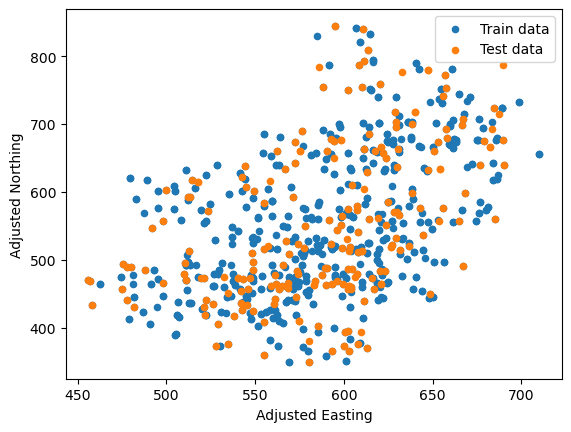

In [69]:
plt.scatter(train_m_v['east']-9435000, train_m_v['north']-4523000, label='Train data',s=20)
plt.scatter(test_m_v['east']-9435000, test_m_v['north']-4523000, label='Test data',s=20)
plt.xlabel('Adjusted Easting')
plt.ylabel('Adjusted Northing')
plt.legend()
plt.savefig('Train vs Test - Top view.png', bbox_inches='tight')

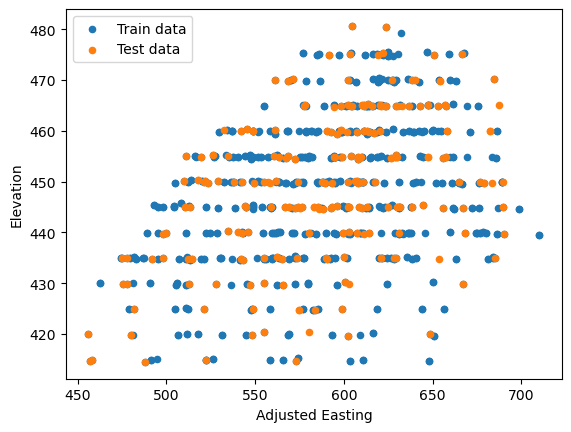

In [70]:
plt.scatter(train_m_v['east']-9435000, train_m_v['elev'], label='Train data',s=20)
plt.scatter(test_m_v['east']-9435000, test_m_v['elev'], label='Test data',s=20)
plt.xlabel('Adjusted Easting')
plt.ylabel('Elevation')
plt.legend()
plt.savefig('Train vs Test - Side view 1.png', bbox_inches='tight')

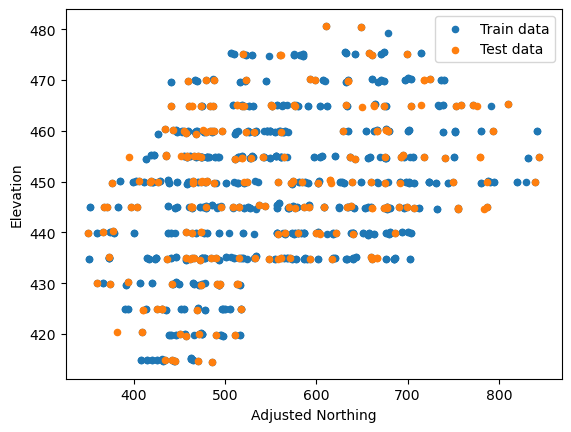

In [71]:
plt.scatter(train_m_v['north']-4523000, train_m_v['elev'], label='Train data',s=20)
plt.scatter(test_m_v['north']-4523000, test_m_v['elev'], label='Test data',s=20)
plt.xlabel('Adjusted Northing')
plt.ylabel('Elevation')
plt.legend()
plt.savefig('Train vs Test - Side view 2.png', bbox_inches='tight')

In [45]:
train_m_v.to_excel('train_data.xlsx')

In [44]:
test_m_v.to_excel('test_data.xlsx')

#### Linear quantile regression

In [ ]:
start_t = time.time()
models_lqr_m_v, predictions_lqr_m_v = store_ml_model_data('Linear model', 
                                                          X_train_scaled_m_v, 
                                                          y_train_m_v, 
                                                          X_test_scaled_m_v, 
                                                          y_test_m_v, 
                                                          k_folds, 
                                                          quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_lqr_m_v, quantiles, predictors_m_v, targets[1])

#### Gradient boosted trees quantile regression

In [ ]:
start_t = time.time()
models_gt_m_v, predictions_gt_m_v = store_ml_model_data('Gradient trees', 
                                                        X_train_scaled_m_v, 
                                                        y_train_m_v, 
                                                        X_test_scaled_m_v, 
                                                        y_test_m_v, 
                                                        k_folds, 
                                                        quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_gt_m_v, quantiles, predictors_m_v, targets[1])

#### Histogram-based gradient trees quantile regression

In [ ]:
start_t = time.time()
models_hbgt_m_v, predictions_hbgt_m_v = store_ml_model_data('Histogram-based gradient trees', 
                                                            X_train_scaled_m_v, 
                                                            y_train_m_v, 
                                                            X_test_scaled_m_v, 
                                                            y_test_m_v, 
                                                            k_folds, 
                                                            quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_hbgt_m_v, quantiles, predictors_m_v, targets[1])

### Horizontal movement devation prediction

#### Feature selection

In [ ]:
plot_binned_scatterplots(df, 'm_h_ff', 'm_h_dev', bin_list=[5, 10, 15], tau=0.9)

In [ ]:
plot_binned_scatterplots(df, 'm_v', 'm_h_dev', bin_list=[5, 10, 15], tau=0.9)

#### Training preparation

In [ ]:
k_folds = 5
partition = 0.2

In [ ]:
predictors_m_h_dev = [
    'm_h_ff',
    'm_v'
]

In [ ]:
train_m_h_dev, test_m_h_dev = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_h_dev, y_train_m_h_dev = train_m_h_dev[predictors_m_h_dev], train_m_h_dev[targets[2]]
X_test_m_h_dev, y_test_m_h_dev = test_m_h_dev[predictors_m_h_dev], test_m_h_dev[targets[2]]

# Initialize QuantileTransformer for the target column
x_scaler_m_h_dev = StandardScaler()

# Scale X (features)
X_train_scaled_m_h_dev = x_scaler_m_h_dev.fit_transform(X_train_m_h_dev)
X_test_scaled_m_h_dev = x_scaler_m_h_dev.transform(X_test_m_h_dev)

#### Linear quantile regression

In [ ]:
start_t = time.time()
models_lqr_m_h_dev, predictions_lqr_m_h_dev = store_ml_model_data('Linear model', 
                                                                  X_train_scaled_m_h_dev, 
                                                                  y_train_m_h_dev, 
                                                                  X_test_scaled_m_h_dev, 
                                                                  y_test_m_h_dev, 
                                                                  k_folds, 
                                                                  quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_lqr_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

#### Gradient boosted trees quantile regression

In [ ]:
start_t = time.time()
models_gt_m_h_dev, predictions_gt_m_h_dev = store_ml_model_data('Gradient trees', 
                                                                X_train_scaled_m_h_dev, 
                                                                y_train_m_h_dev, 
                                                                X_test_scaled_m_h_dev, 
                                                                y_test_m_h_dev, 
                                                                k_folds, 
                                                                quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_gt_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

#### Histogram-based gradient trees quantile regression

In [ ]:
start_t = time.time()
models_hbgt_m_h_dev, predictions_hbgt_m_h_dev = store_ml_model_data('Histogram-based gradient trees', 
                                                                    X_train_scaled_m_h_dev, 
                                                                    y_train_m_h_dev, 
                                                                    X_test_scaled_m_h_dev, 
                                                                    y_test_m_h_dev, 
                                                                    k_folds, 
                                                                    quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_hbgt_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

### Post-blast detection depth prediction

#### Feature selection

In [ ]:
plot_binned_scatterplots(df, 'det_h', 'det_depth', bin_list=[5, 10, 15], tau=0.8)

#### Training preparation

In [ ]:
k_folds = 5
partition = 0.2

In [ ]:
predictors_det_depth = [
    'det_h'
]

In [ ]:
train_det_depth, test_det_depth = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_det_depth, y_train_det_depth = train_det_depth[predictors_det_depth], train_det_depth[targets[3]]
X_test_det_depth, y_test_det_depth = test_det_depth[predictors_det_depth], test_det_depth[targets[3]]

# Initialize QuantileTransformer for the target column
x_scaler_det_depth = StandardScaler()

# Scale X (features)
X_train_scaled_det_depth = x_scaler_det_depth.fit_transform(X_train_det_depth)
X_test_scaled_det_depth = x_scaler_det_depth.transform(X_test_det_depth)

#### Linear qunatile regression

In [ ]:
start_t = time.time()
models_lqr_det_depth, predictions_lqr_det_depth = store_ml_model_data('Linear model', 
                                                                      X_train_scaled_det_depth, 
                                                                      y_train_det_depth, 
                                                                      X_test_scaled_det_depth, 
                                                                      y_test_det_depth, 
                                                                      k_folds, 
                                                                      quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_lqr_det_depth, quantiles, predictors_det_depth, targets[3])

#### Gradient boosted trees quantile regression

In [ ]:
start_t = time.time()
models_gt_det_depth, predictions_gt_det_depth = store_ml_model_data('Gradient trees', 
                                                                    X_train_scaled_det_depth, 
                                                                    y_train_det_depth, 
                                                                    X_test_scaled_det_depth, 
                                                                    y_test_det_depth, 
                                                                    k_folds, 
                                                                    quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_gt_det_depth, quantiles, predictors_det_depth, targets[3])

#### Histogram-based gradient trees quantile regression

In [ ]:
start_t = time.time()
models_hbgt_det_depth, predictions_hbgt_det_depth = store_ml_model_data('Histogram-based gradient trees', 
                                                                        X_train_scaled_det_depth, 
                                                                        y_train_det_depth, 
                                                                        X_test_scaled_det_depth, 
                                                                        y_test_det_depth, 
                                                                        k_folds, 
                                                                        quantiles)
finish_t = time.time()

In [ ]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

In [ ]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_hbgt_det_depth, quantiles, predictors_det_depth, targets[3])

### Model comparison and practical evaluation

In roder to evaluate all models and determine their practilcal use, a function was defined which can plot the predicted conditional CDF of a target feature for an arbitrary set of conditions.

In [ ]:
def plot_pred_cdf(index, pred_dict, target):
    y = []
    x_lqr = []
    x_gt = []
    x_hbgt = []

    plt.figure(figsize=(7, 4))
    for i in pred_dict['lqr'].keys():
        y.append(i)
        x_lqr.append(pred_dict['lqr'][i][index])
        x_gt.append(pred_dict['gt'][i][index])
        x_hbgt.append(pred_dict['hbgt'][i][index])
    plt.plot(x_lqr, y, color='tab:blue', label='Linear model')
    plt.plot(x_gt, y, color='tab:orange', label='Gradient trees')
    plt.plot(x_hbgt, y, color='tab:green', label='Histogram-based GT')
    plt.legend()
    plt.title('Predicted observation CDF')
    plt.ylabel('Cumulative Density')

An arbitrary sample index can be used to examine the level of agreement between all models and the quality of reproducing the conditional distribution of all predicted blast movement features.

In [ ]:
sample_index = 123

In [ ]:
pred_dict_m_h_ff = {
    'lqr': predictions_lqr_m_h_ff,
    'gt': predictions_gt_m_h_ff,
    'hbgt': predictions_hbgt_m_h_ff,
}

plot_pred_cdf(sample_index, pred_dict_m_h_ff, 'm_h_ff')

plt.xlabel('m_h_ff')
plt.show()

The first results is very good. It shows a good agreement for all models for all parts of the CDF. The least amount of agreement is observed near the median, however, this is due to the larger quantile error in this region.

In [ ]:
pred_dict_m_v = {
    'lqr': predictions_lqr_m_v,
    'gt': predictions_gt_m_v,
    'hbgt': predictions_hbgt_m_v,
}

plot_pred_cdf(sample_index, pred_dict_m_v, 'm_v')
plt.xlabel('m_v')
plt.show()

Alhough the Histogram-based regression model is quicker it fails to capture some peculiarities of the conditional distribution. Nonetheles, all models perform evidently well, including on the tails of the distribution.

In [ ]:
pred_dict_m_h_dev = {
    'lqr': predictions_lqr_m_h_dev,
    'gt': predictions_gt_m_h_dev,
    'hbgt': predictions_hbgt_m_h_dev,
}

plot_pred_cdf(sample_index, pred_dict_m_h_dev, 'm_h_dev')
plt.xlabel('m_h_dev')
plt.show()

It would seem that there is a good agreement for all models for this parameter. Moreover, the estimated CDF is not fully flat, which indicates a non-uniform behavor.

In [ ]:
pred_dict_det_depth = {
    'lqr': predictions_lqr_det_depth,
    'gt': predictions_gt_det_depth,
    'hbgt': predictions_hbgt_det_depth,
}

plot_pred_cdf(sample_index, pred_dict_det_depth, 'det_depth')
plt.xlabel('det_depth')
plt.show()

Once, more the CDF function seems to be estimated well by all models, disregarding the potential addition of artifacts. However, the linear model seems to be more biased towards smaller values for the detection depth.

## Models deployment

Now that we know that the considered regressors can model the conditional distribution of certain engineering conditions based on the assumed features, let's export all integer-value percentiles between 1 and 99 for the purpose of using them for conditional simulation, based on a random draw of a regression model, corresponding to each percentile.

Although certain artifacts can be introduced in the predicted distribution, based on all regressors, the overall predicted distribution follows the actual one or the one, which can be estimated through a best-fit parametric model. Hence, for practical use a random draw of a regressor is assumed to be a good alternative for a trial simulation,

In [ ]:
import joblib
import os

In [ ]:
quantiles = np.arange(0.01, 1.0, 0.01)

In [ ]:
all_models_lqr_m_h_ff, all_predictions_lqr_m_h_ff = store_ml_model_data('Linear model', 
                                                                        X_train_scaled_m_h_ff, 
                                                                        y_train_m_h_ff, 
                                                                        X_test_scaled_m_h_ff, 
                                                                        y_test_m_h_ff, 
                                                                        k_folds, 
                                                                        quantiles)

In [ ]:
all_models_lqr_m_v, all_predictions_lqr_m_v = store_ml_model_data('Linear model', 
                                                                  X_train_scaled_m_v, 
                                                                  y_train_m_v, 
                                                                  X_test_scaled_m_v, 
                                                                  y_test_m_v, 
                                                                  k_folds, 
                                                                  quantiles)

In [ ]:
all_models_lqr_m_h_dev, all_predictions_lqr_m_h_dev = store_ml_model_data('Linear model', 
                                                                  X_train_scaled_m_h_dev, 
                                                                  y_train_m_h_dev, 
                                                                  X_test_scaled_m_h_dev, 
                                                                  y_test_m_h_dev, 
                                                                  k_folds, 
                                                                  quantiles)

In [ ]:
all_models_lqr_det_depth, all_predictions_lqr_det_depth = store_ml_model_data('Linear model', 
                                                                              X_train_scaled_det_depth, 
                                                                              y_train_det_depth, 
                                                                              X_test_scaled_det_depth, 
                                                                              y_test_det_depth, 
                                                                              k_folds, 
                                                                              quantiles)

Everything seems to be in order. Most quantile losses are low, which is indicative that for a trial process the conditional simulation can be based on a random draw of a regression model.

Last but not least, we need to export all models for the simulation stage of the project.

In [ ]:
import joblib
import pickle

In [ ]:
target_names = ['m_h_ff', 'm_v', 'm_h_dev', 'det_depth']
model_folder = "New Models"
model_dicts = {
    'm_h_ff': all_models_lqr_m_h_ff,
    'm_v': all_models_lqr_m_v,
    'm_h_dev': all_models_lqr_m_h_dev,
    'det_depth': all_models_lqr_det_depth
}

for q in quantiles:
    q = np.round(q, 2)
    for target in target_names:
        target_folder = os.path.join(model_folder, target)
        os.makedirs(target_folder, exist_ok=True)
        
        model_file = f"regressor_model_{target}_{q}.pkl"
        model_path = os.path.join(target_folder, model_file)
        
        model_to_save = model_dicts[target].get(q)
        if model_to_save:
            joblib.dump(model_to_save, model_path)
            print(f"Model {target}_{q} saved to {model_path}")
        else:
            print(f"No model found for {target}_{q}")

In [ ]:
for target in target_names:
    target_folder = os.path.join(model_folder, target)
    os.makedirs(target_folder, exist_ok=True)
    model_file = f'x_scaler_{target}.pkl'
    model_path = os.path.join(target_folder, model_file)
    
    if target == 'm_h_ff':
        joblib.dump(x_scaler_m_h_ff, model_path)
    elif target == 'm_v':
        joblib.dump(x_scaler_m_v, model_path)
    elif target == 'm_h_dev':
        joblib.dump(x_scaler_m_h_dev, model_path)
    elif target == 'det_depth':
        joblib.dump(x_scaler_det_depth, model_path)

    print(f"Scaler {target} saved to {model_path}")

## Conclusions

All considered models seem to capture the overall distribution of the sampled engineering conditions, deeming the potentially feasible for real-life implementation. Hence, a chained regression strategy, based on quantile regression is suitable for the obtained dataset.
Moreover, given that certain quantiles are predicted, a parametric model, based on CDF-fitting can be obtained for the purpose of conditional simulation.

So far a linear model seems to be well-suited in terms of predictive capacity, as well fast enough both for training and predictions. Hence, a trial use case is based on its implementation. Please check **Vol. 3** for a demo of using the exported models, used for simulating blast movement.